In [1]:
try:
  %tensorflow_version 2.x  # Colab only.
except Exception:
  pass

import tensorflow as tf
print(tf.__version__)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
2.12.0


In [2]:
# More imports
from tensorflow.keras.layers import Input, Dense, LeakyReLU, Dropout, BatchNormalization
from tensorflow.keras.activations import gelu
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os

In [3]:
# Load in the data
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

# map inputs to (-1, +1) for better training
x_train, x_test = x_train / 255.0 * 2 - 1, x_test / 255.0 * 2 - 1
print("x_train.shape:", x_train.shape)

11490434/11490434 [==============================] - 2s 0us/step
x_train.shape: (60000, 28, 28)


In [4]:
# Flatten the data
N, H, W = x_train.shape
D = H * W
x_train = x_train.reshape(-1, D)
x_test = x_test.reshape(-1, D)

In [5]:
# Dimensionality of the latent space
latent_dim = 100

In [6]:
# Get the generator model
def build_generator(latent_dim):
  i = Input(shape=(latent_dim,))
  x = Dense(256, activation=LeakyReLU(alpha=0.2))(i)
  x = BatchNormalization(momentum=0.7)(x)
  x = Dense(512, activation=LeakyReLU(alpha=0.2))(x)
  x = BatchNormalization(momentum=0.7)(x)
  x = Dense(1024, activation=LeakyReLU(alpha=0.2))(x)
  x = BatchNormalization(momentum=0.7)(x)
  x = Dense(D, activation='tanh')(x)

  model = Model(i, x)
  return model

In [7]:
# Get the discriminator model
def build_discriminator(img_size):
  i = Input(shape=(img_size,))
  x = Dense(512, activation=LeakyReLU(alpha=0.2))(i)
  x = Dense(256, activation=LeakyReLU(alpha=0.2))(x)
  x = Dense(1, activation='sigmoid')(x)
  model = Model(i, x)
  return model

In [8]:
# Compile both models in preparation for training


# Build and compile the discriminator
discriminator = build_discriminator(D)
discriminator.compile(
    loss='binary_crossentropy',
    optimizer=Adam(0.0002, 0.5),
    metrics=['accuracy'])

# Build and compile the combined model
generator = build_generator(latent_dim)

# Create an input to represent noise sample from latent space
z = Input(shape=(latent_dim,))

# Pass noise through generator to get an image
img = generator(z)

# Make sure only the generator is trained
discriminator.trainable = False

# The true output is fake, but we label them real!
fake_pred = discriminator(img)

# Create the combined model object
combined_model = Model(z, fake_pred)

# Compile the combined model
combined_model.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

In [9]:
# Train the GAN


# Config
batch_size = 512#32
epochs = 30000
sample_period = 512 # every `sample_period` steps generate and save some data


# Create batch labels to use when calling train_on_batch
ones = np.ones(batch_size)
zeros = np.zeros(batch_size)

# Store the losses
d_losses = []
g_losses = []

# Create a folder to store generated images
if not os.path.exists('gan_images'):
  os.makedirs('gan_images')

In [10]:
# A function to generate a grid of random samples from the generator
# and save them to a file
def sample_images(epoch):
  rows, cols = 5, 5
  noise = np.random.randn(rows * cols, latent_dim)
  imgs = generator.predict(noise)

  # Rescale images 0 - 1
  imgs = 0.5 * imgs + 0.5

  fig, axs = plt.subplots(rows, cols)
  idx = 0
  for i in range(rows):
    for j in range(cols):
      axs[i,j].imshow(imgs[idx].reshape(H, W), cmap='gray')
      axs[i,j].axis('off')
      idx += 1
  fig.savefig("gan_images/%d.png" % epoch)
  plt.close()

In [11]:
# Main training loop
for epoch in range(epochs):
  ###########################
  ### Train discriminator ###
  ###########################
  
  # Select a random batch of images
  idx = np.random.randint(0, x_train.shape[0], batch_size)
  real_imgs = x_train[idx]
  
  # Generate fake images
  noise = np.random.randn(batch_size, latent_dim)
  fake_imgs = generator.predict(noise)
  
  # Train the discriminator
  # both loss and accuracy are returned
  d_loss_real, d_acc_real = discriminator.train_on_batch(real_imgs, ones)
  d_loss_fake, d_acc_fake = discriminator.train_on_batch(fake_imgs, zeros)
  d_loss = 0.5 * (d_loss_real + d_loss_fake)
  d_acc  = 0.5 * (d_acc_real + d_acc_fake)
  
  
  #######################
  ### Train generator ###
  #######################
  
  noise = np.random.randn(batch_size, latent_dim)
  g_loss = combined_model.train_on_batch(noise, ones)
  
  # do it again!
  noise = np.random.randn(batch_size, latent_dim)
  g_loss = combined_model.train_on_batch(noise, ones)
  
  # Save the losses
  d_losses.append(d_loss)
  g_losses.append(g_loss)
  
  if epoch % 100 == 0:
    print(f"epoch: {epoch+1}/{epochs}, d_loss: {d_loss:.2f}, \
      d_acc: {d_acc:.2f}, g_loss: {g_loss:.2f}")
  
  if epoch % sample_period == 0:
    sample_images(epoch)

Streaming output truncated to the last 5000 lines.
8/8 [==============================] - 0s 3ms/step
epoch: 25101/30000, d_loss: 0.58,       d_acc: 0.69, g_loss: 1.03
8/8 [==============================] - 0s 3ms/step
epoch: 25201/30000, d_loss: 0.63,       d_acc: 0.63, g_loss: 1.07
8/8 [==============================] - 0s 3ms/step
epoch: 25301/30000, d_loss: 0.59,       d_acc: 0.68, g_loss: 1.11
8/8 [==============================] - 0s 3ms/step
epoch: 25401/30000, d_loss: 0.59,       d_acc: 0.67, g_loss: 1.15
8/8 [==============================] - 0s 2ms/step
epoch: 25501/30000, d_loss: 0.61,       d_acc: 0.68, g_loss: 1.07
8/8 [==============================] - 0s 3ms/step
epoch: 25601/30000, d_loss: 0.61,       d_acc: 0.67, g_loss: 1.08
8/8 [==============================] - 0s 4ms/step
epoch: 25701/30000, d_loss: 0.62,       d_acc: 0.65, g_loss: 1.06
8/8 [==============================] - 0s 3ms/step
epoch: 25801/30000, d_loss: 0.61,       d_acc: 0.67, g_loss: 1.09
8/8 [========

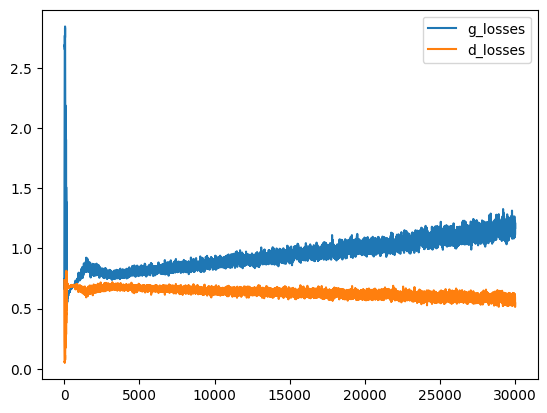

In [12]:
plt.plot(g_losses, label='g_losses')
plt.plot(d_losses, label='d_losses')
plt.legend()

In [13]:
!ls gan_images

0.png	   13824.png  17920.png  22016.png  26112.png  3584.png  7680.png
10240.png  14336.png  18432.png  22528.png  26624.png  4096.png  8192.png
1024.png   14848.png  18944.png  23040.png  27136.png  4608.png  8704.png
10752.png  15360.png  19456.png  23552.png  27648.png  5120.png  9216.png
11264.png  1536.png   19968.png  24064.png  28160.png  512.png	 9728.png
11776.png  15872.png  20480.png  24576.png  28672.png  5632.png
12288.png  16384.png  2048.png	 25088.png  29184.png  6144.png
12800.png  16896.png  20992.png  25600.png  29696.png  6656.png
13312.png  17408.png  21504.png  2560.png   3072.png   7168.png


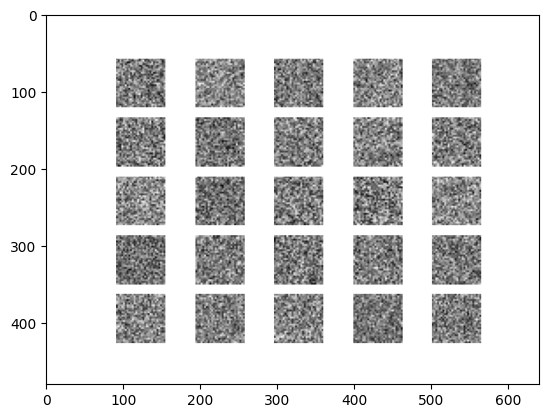

In [14]:
from skimage.io import imread
a = imread('gan_images/0.png')
plt.imshow(a)

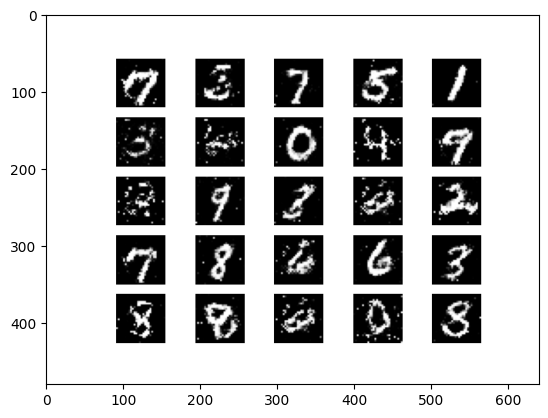

In [15]:
a = imread('gan_images/13312.png')
plt.imshow(a)

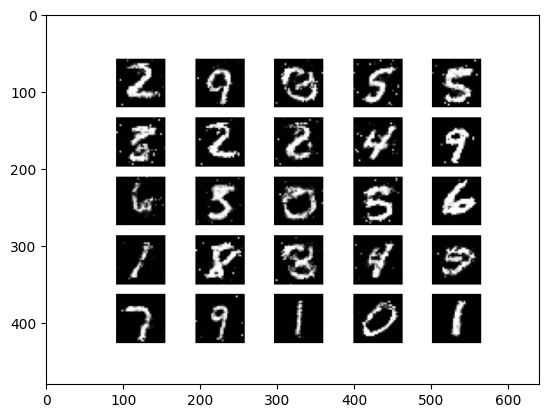

In [16]:
a = imread('gan_images/20480.png')
plt.imshow(a)

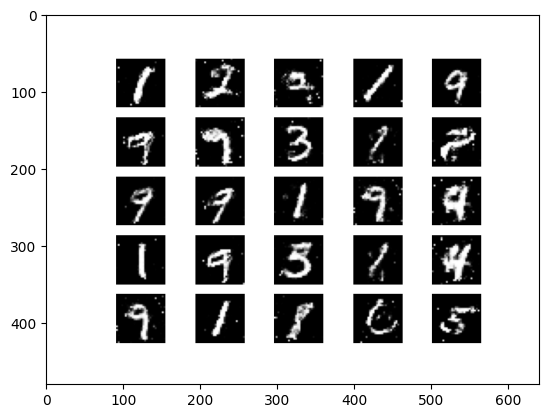

In [17]:
a = imread('gan_images/29696.png')
plt.imshow(a)

In [18]:
generator.save('generator.h5')

In [20]:
combined_model.save('combined.h5')

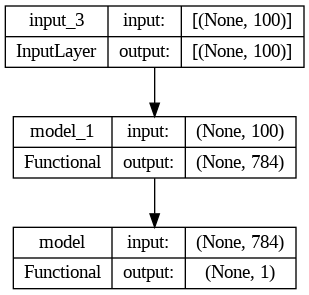

In [21]:
from tensorflow.keras.utils import plot_model
plot_model(combined_model, 'encoder_compress.png', show_shapes=True)

In [ ]:
model = tf.keras.models.load_model('generator.h5')

In [19]:
from google.colab import files
files.download('generator.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [22]:
files.download('combined.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>